In [1]:
from droplet_growth import register, mic, poisson, fit

from droplet_growth import multiwell as mw
from glob import glob
import tifffile as tf
import matplotlib.pyplot as plt
import numpy as np
from functools import partial, reduce
from operator import add
import pandas as pd
import re
from multiprocessing import Pool
import os
import seaborn as sns

from scipy import ndimage as ndi
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/home/aaristov/Documents/nd2shrink


In [5]:
pd.concat([pd.read_csv(a, index_col=None) for a in glob('/home/aaristov/Anchor/Lena/Data/20220111-MIC-resistant/day1/composites/*ng-Composite.aligned-counts.csv')], ignore_index=True)

label            x             y  n_cells  ng  poisson fit
0         1   663.248626    417.128241        0  64     0.814698
1         2   664.647675    948.961450        0  64     0.814698
2         3   665.043884   1475.729516        4  64     0.814698
3         4   661.226322  16298.040220        2  64     0.814698
4         5   660.757642  16826.050217        1  64     0.814698
...     ...          ...           ...      ...  ..          ...
3502    497  5962.000000   4646.000000        0  32     0.845120
3503    498  5961.897296   5177.702880        4  32     0.845120
3504    499  5961.526499   5706.998255        0  32     0.845120
3505    500  5961.537016   6236.971642        1  32     0.845120
3506    501  5961.585169   6765.801022        1  32     0.845120

[3507 rows x 6 columns]

In [8]:
counts_day1 = pd.concat([pd.read_csv(a, index_col=None) for a in glob('/home/aaristov/Anchor/Lena/Data/20220111-MIC-resistant/day1/composites/*ng-Composite.aligned-counts.csv')], ignore_index=True).sort_values(['ng','label']).reset_index()
counts_day2 = pd.concat([pd.read_csv(a, index_col=None) for a in glob('/home/aaristov/Anchor/Lena/Data/20220111-MIC-resistant/day2/Composites/*ng-BF-TRIRC-2D.aligned-counts.csv')], ignore_index=True).sort_values(['ng','label']).reset_index()


In [10]:
np.testing.assert_array_equal(counts_day1[['ng','label']].query('ng > 0'), counts_day2[['ng','label']],)

In [11]:
table = counts_day1.query('ng > 0').copy()
table.loc[:,'n24'] = counts_day2.n_cells
table

index  label            x             y  n_cells   ng  poisson fit  n24
501    3006      1   663.248626    417.128241        1   32     0.845120  0.0
502    3007      2   664.647675    948.961450        1   32     0.845120  0.0
503    3008      3   665.043884   1475.729516        3   32     0.845120  1.0
504    3009      4   661.226322  16298.040220        1   32     0.845120  2.0
505    3010      5   660.757642  16826.050217        0   32     0.845120  2.0
...     ...    ...          ...           ...      ...  ...          ...  ...
3502    997    497  5962.000000   4646.000000        0  256     0.900429  NaN
3503    998    498  5961.897296   5177.702880        0  256     0.900429  NaN
3504    999    499  5961.526499   5706.998255        2  256     0.900429  NaN
3505   1000    500  5961.537016   6236.971642        0  256     0.900429  NaN
3506   1001    501  5961.585169   6765.801022        3  256     0.900429  NaN

[3006 rows x 8 columns]

In [12]:
table.loc[:, 'final_state'] = table.n24 > 10

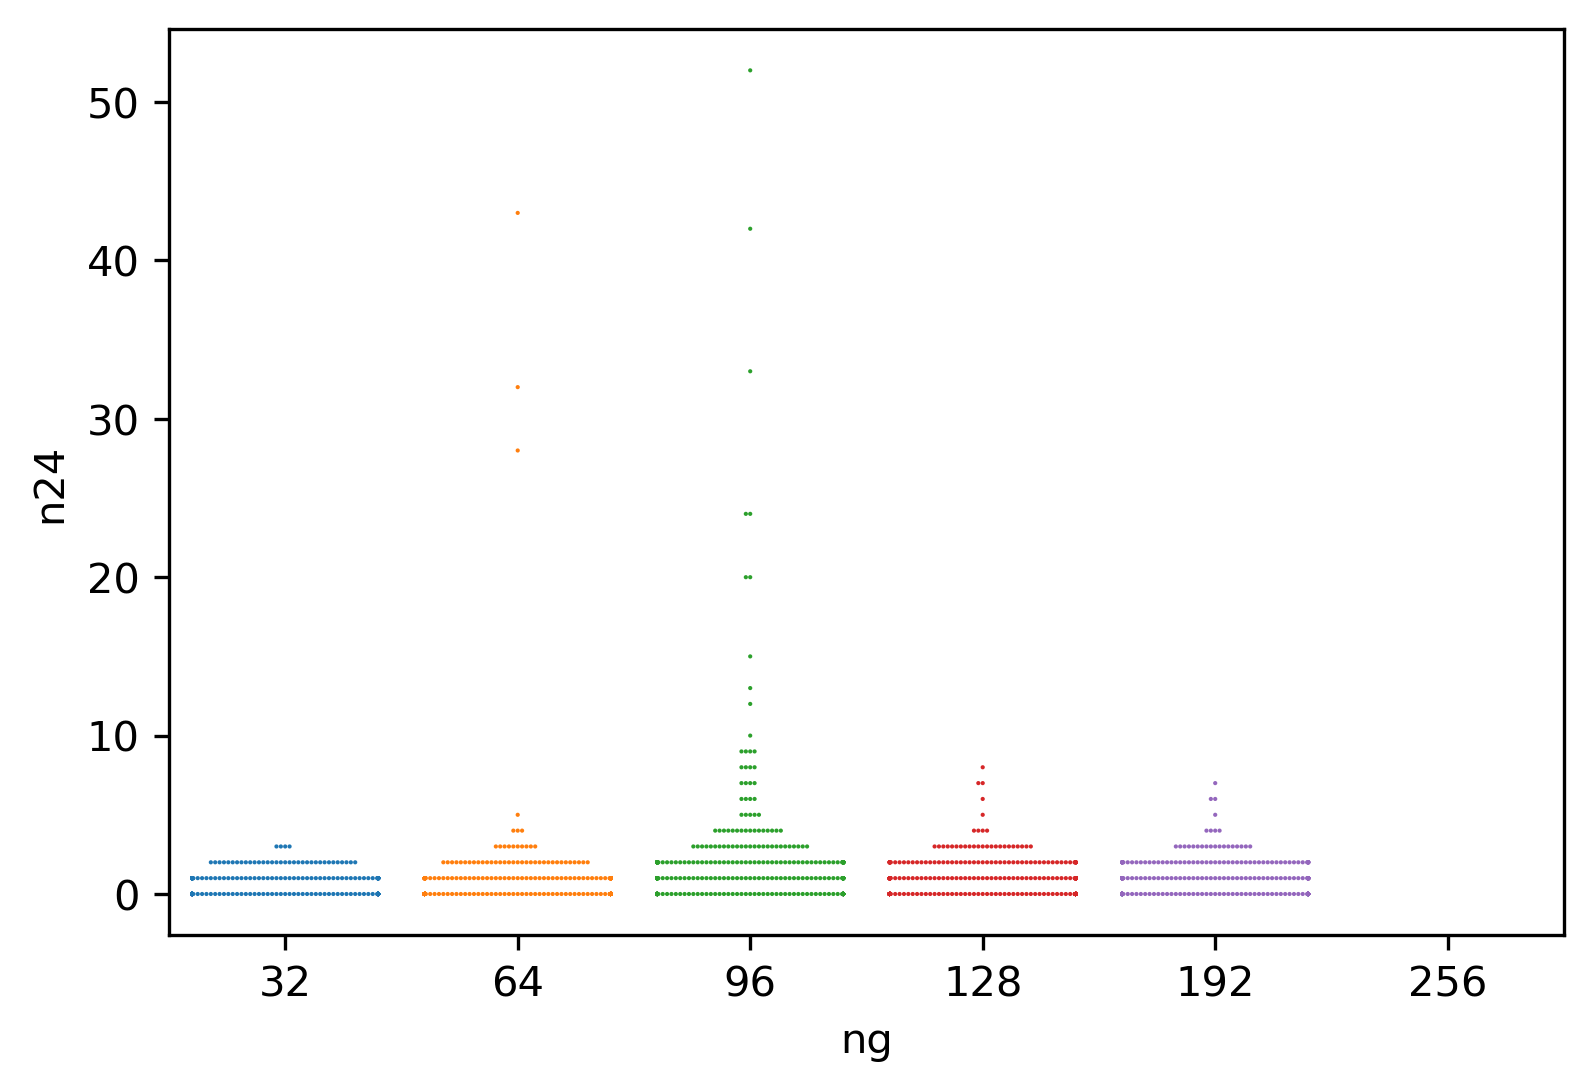

In [13]:
fig, ax = plt.subplots(dpi=300)
sns.swarmplot(ax=ax, data=table, x='ng', y='n24', size=1)

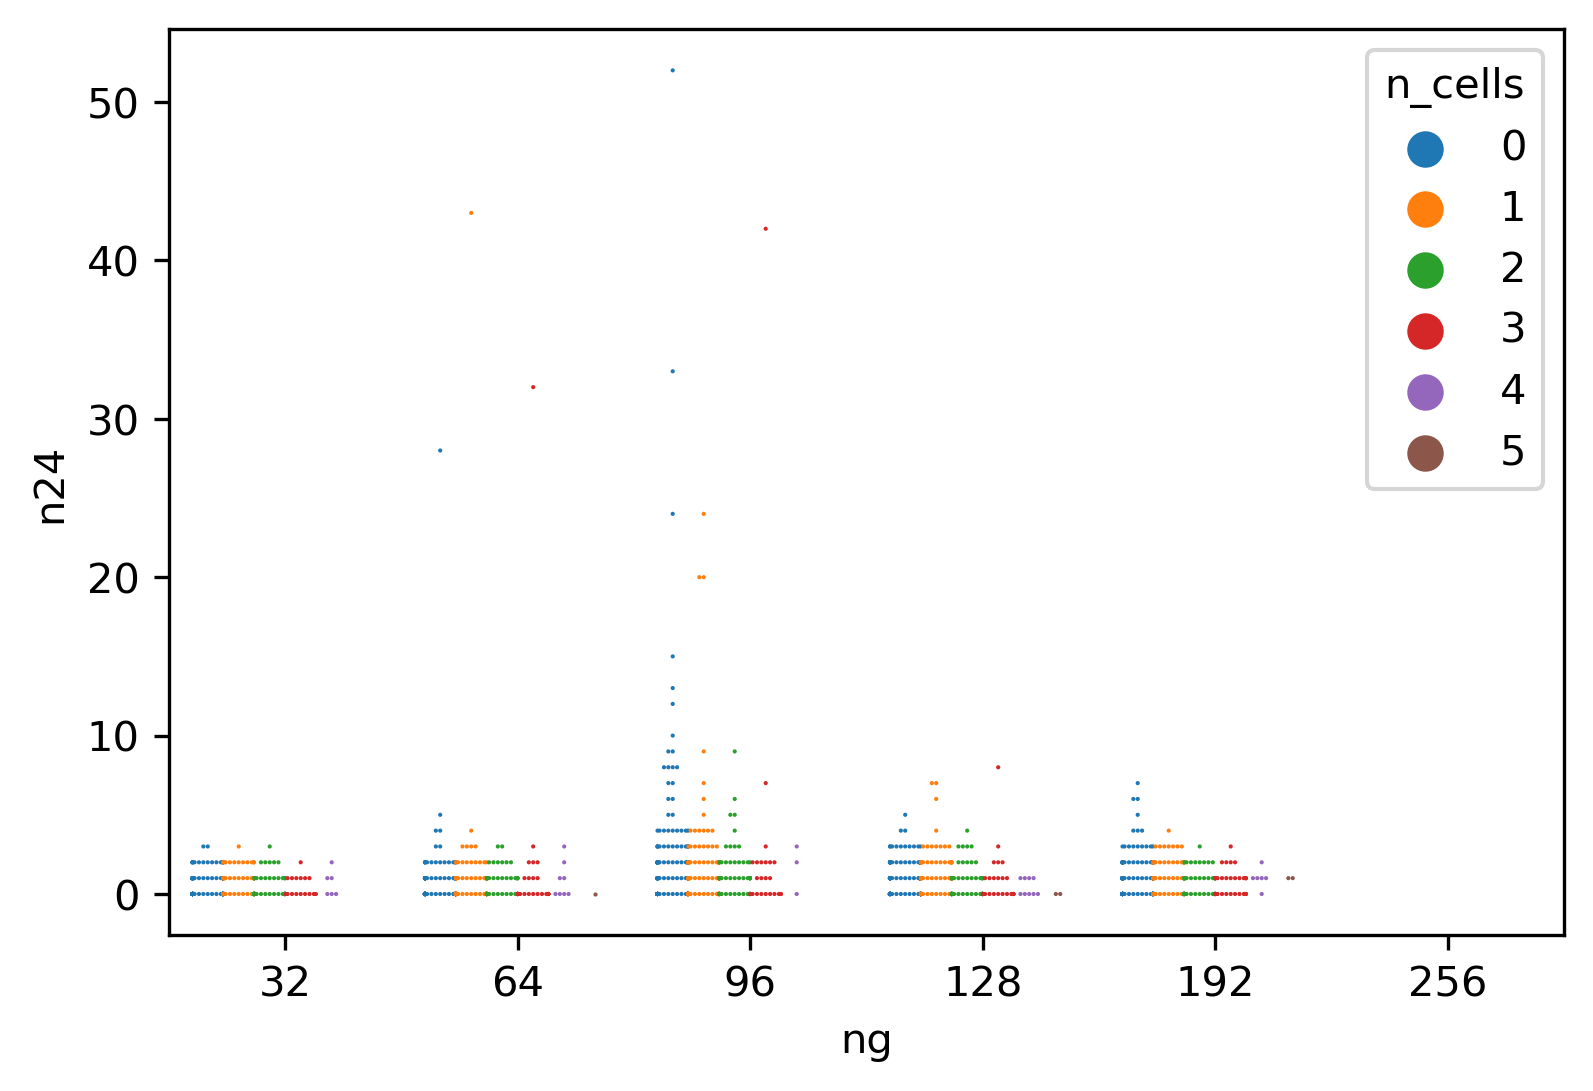

In [14]:
fig, ax = plt.subplots(dpi=300)
sns.swarmplot(ax=ax, data=table.query('n_cells < 6'), x='ng', y='n24', hue='n_cells', dodge=True, size=1)

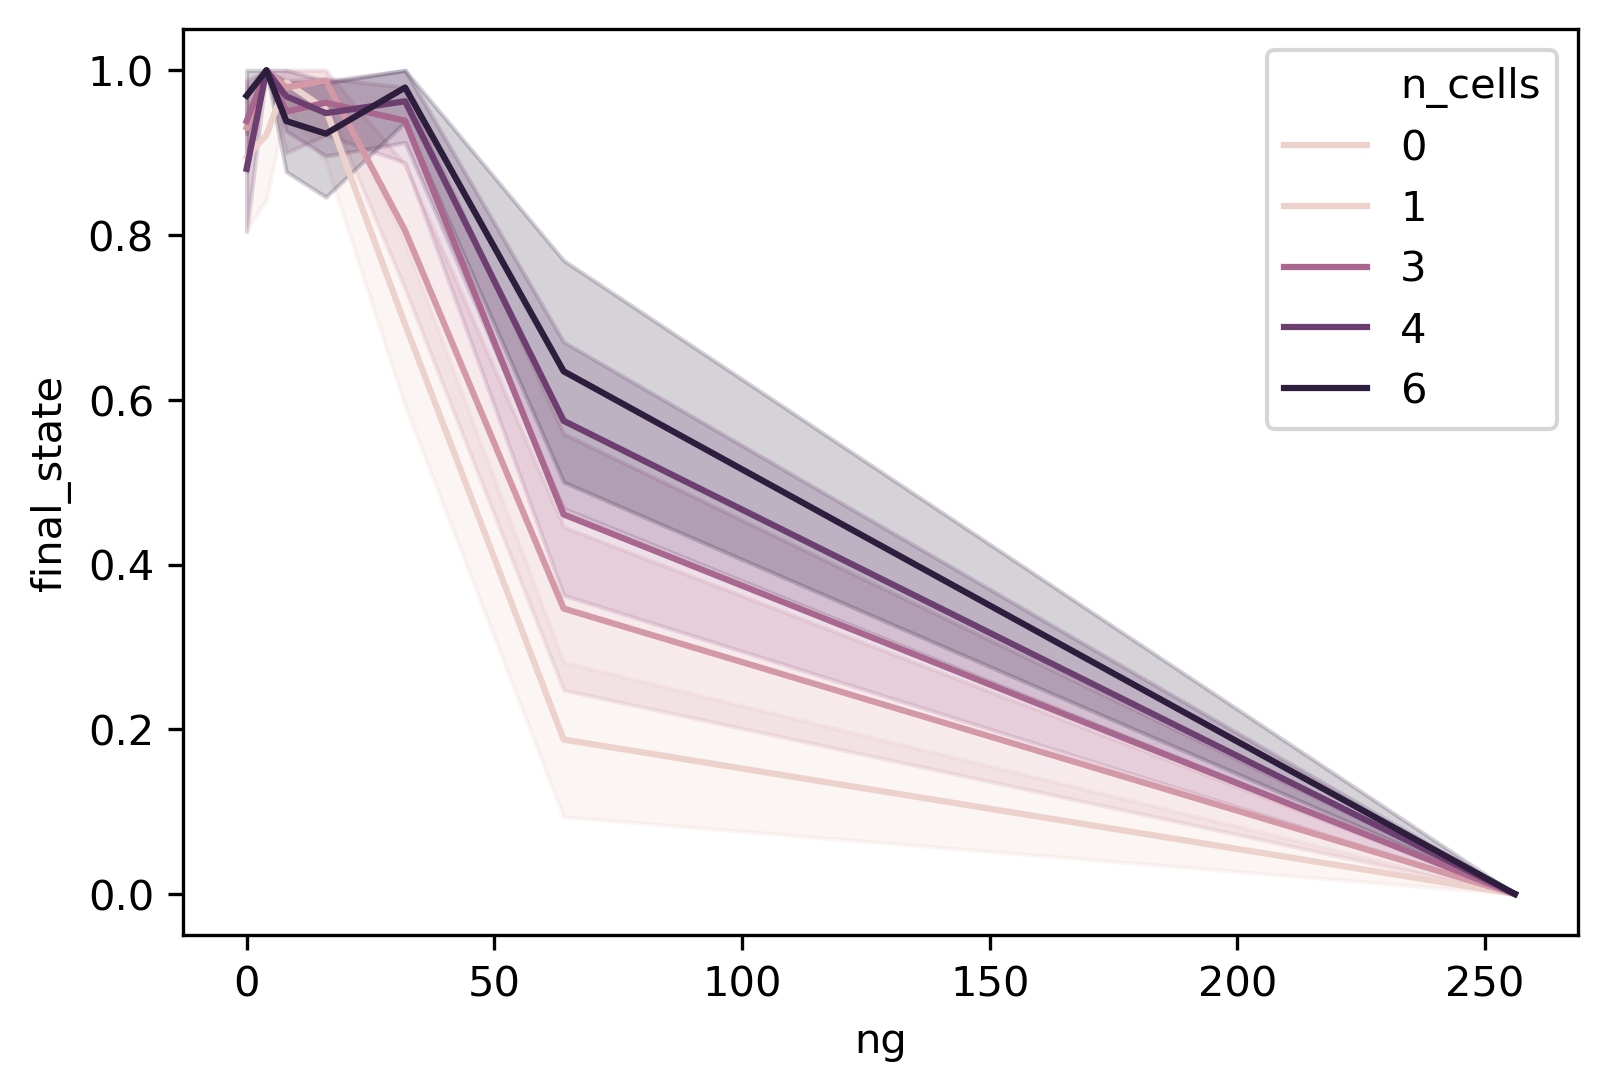

In [75]:
fig, ax = plt.subplots(dpi=300)
sns.lineplot(ax=ax, data=table.query('0 < n_cells < 6'), x='ng', y='final_state', hue='n_cells')

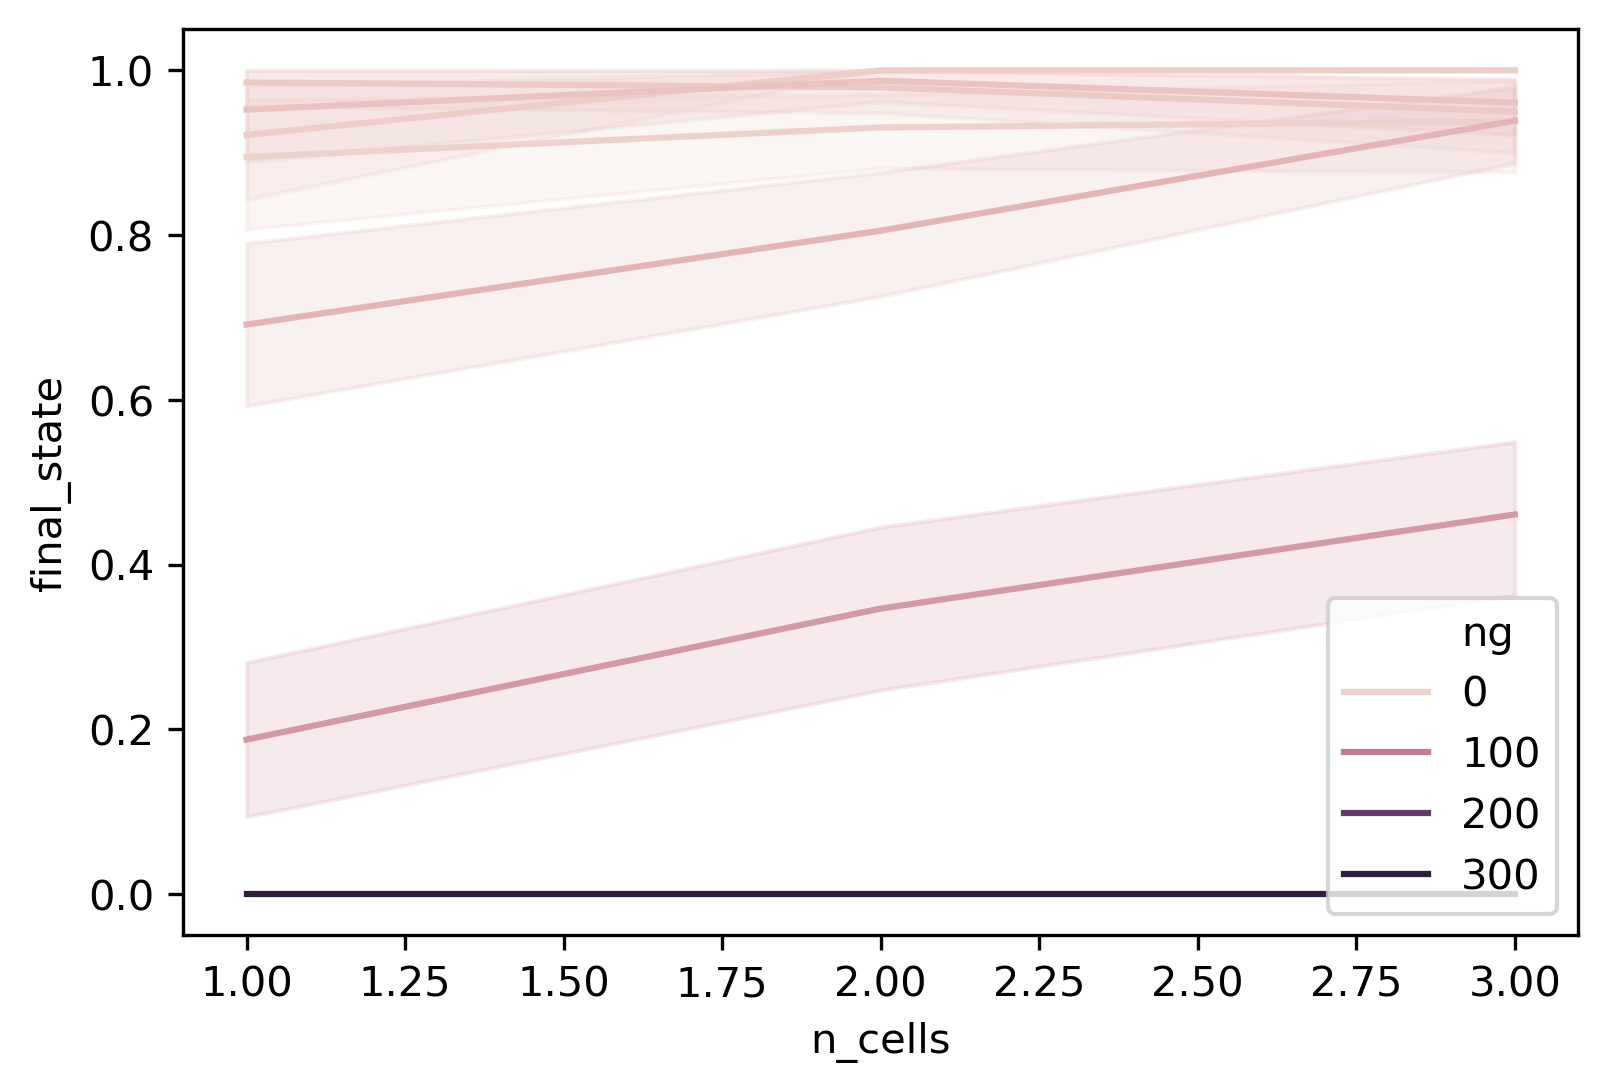

In [70]:
fig, ax = plt.subplots(dpi=300)
sns.lineplot(ax=ax, data=table.query('0 < n_cells < 4'), x='n_cells', y='final_state', hue='ng')

/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


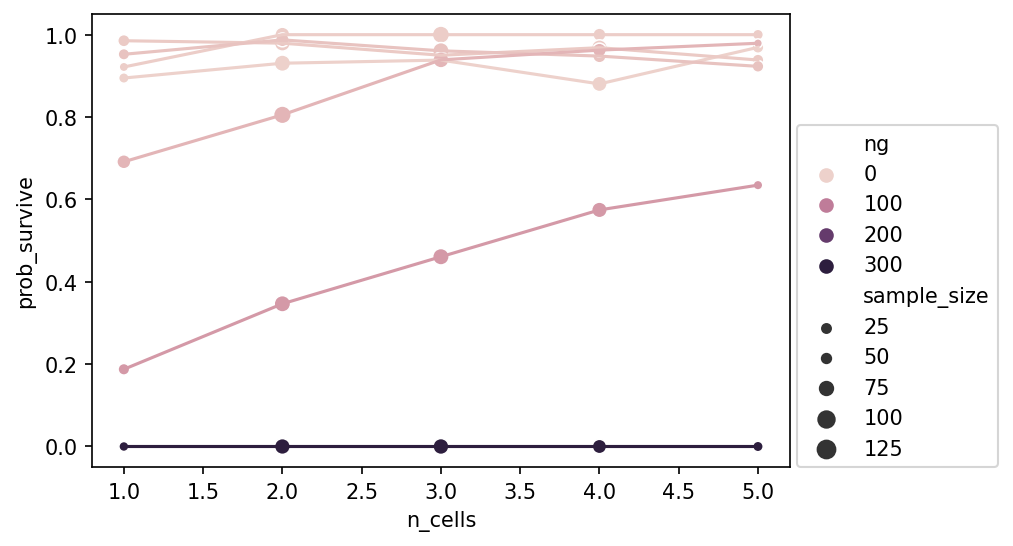

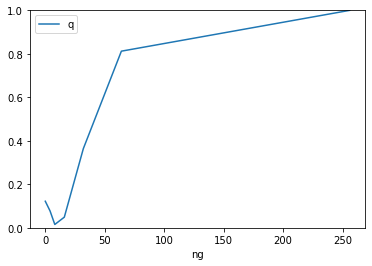

ng  prob_survive         q                precision           MSE
0    0  8.778683e-01  0.122132    [0.07200626939253155]  4.403895e-03
1    4  9.225078e-01  0.077492  [0.0030115249241871073]  7.432083e-06
2    8  9.846318e-01  0.015368     [0.0438533225231097]  1.539945e-03
3   16  9.510692e-01  0.048931    [0.05038137330035266]  2.050177e-03
4   32  6.358702e-01  0.364130   [0.033340139925130075]  1.541582e-03
5   64  1.876595e-01  0.812341  [0.0020551390173563977]  5.709401e-05
6  256  2.181057e-12  1.000000                    [inf]  5.232596e-23

In [74]:
mic.fit.single_prob(mic.get_stats(table, ))